<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/02_Evaluate_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 02 - Comprehensive Benchmark Suite Evaluation

### Exploring GLU Expansion Ratios in Llama-3.2 Models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Evaluate:**
* Llama-3.2-1B (base) - Baseline
* Llama-3.2-1B-pruned-20% (220% expansion)
* Llama-3.2-1B-pruned-40% (140% expansion) ⭐ Star model
* Llama-3.2-1B-pruned-60% (60% expansion)

**Benchmarks (10 total):**
* WikiText-2 Perplexity (0-shot)
* BoolQ (0-shot)
* Lambada-OpenAI (0-shot)
* MMLU (5-shot)
* ARC-Challenge (0-shot)
* HellaSwag (0-shot)
* WinoGrande (0-shot)
* PIQA (0-shot)
* TruthfulQA MC1/MC2 (0-shot)
* GSM8K (5-shot CoT)

**Estimated Runtime:** ~4-5 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [ ]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [4]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG,
    BENCHMARKS_BASE,
    load_or_create_model,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the evaluation plan.

In [5]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG
    if "1B" in config["base_model"] and "3B" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_BASE)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_BASE)}")
print(f"Estimated runtime: ~4-5 hours\n")

# Display models table
print("Models to evaluate:")
print("-" * 70)
print(f"{'Model':<30} {'Pruning':<10} {'Expansion':<12} {'Star':<6}")
print("-" * 70)
print(f"{'Llama-3.2-1B (baseline)':<30} {'0%':<10} {'300%':<12} {'N/A':<6}")
for config in models_1b:
    model_name = config['hf_repo_id'].split('/')[-1]
    pruning = f"{config['pruning_pct']}%"
    expansion = f"{config['expansion_rate']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<30} {pruning:<10} {expansion:<12} {star:<6}")
print("-" * 70)

# Display benchmarks
print("\nBenchmarks to run:")
print("-" * 70)
for i, task in enumerate(BENCHMARKS_BASE, 1):
    task_name = task['name']
    fewshot = f"{task['num_fewshot']}-shot"
    print(f"{i:2d}. {task_name:<25} {fewshot}")
print("-" * 70)

print("\n⚙️  Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-task granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - Error handling: Skip failed tasks and continue\n")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 4
Benchmarks per model: 11
Total evaluations: 44
Estimated runtime: ~4-5 hours

Models to evaluate:
----------------------------------------------------------------------
Model                          Pruning    Expansion    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)        0%         300%         N/A   
Llama-3.2-1B-pruned-20pct      20%        220%         No    
Llama-3.2-1B-pruned-40pct      40%        140%         ⭐ Yes 
Llama-3.2-1B-pruned-60pct      60%        60%          No    
----------------------------------------------------------------------

Benchmarks to run:
----------------------------------------------------------------------
 1. wikitext                  0-shot
 2. boolq                     0-shot
 3. lambada_openai            0-shot
 4. mmlu                      5-shot
 5. arc_challenge             0-shot
 6. hellaswag                 0-sh

In [6]:
# Setup checkpoint paths
CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/1b"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# Define checkpoint paths for each model
checkpoint_paths = {
    "baseline": f"{CHECKPOINT_DIR}/llama_3.2_1b_baseline.json",
    "20pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_20pct.json",
    "40pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_40pct.json",
    "60pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_60pct.json",
}

print("\nCheckpoint files:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"   {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

Checkpoint files:
   baseline  : 🆕 New
   20pct     : 🆕 New
   40pct     : 🆕 New
   60pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 1: BASELINE EVALUATION")
print(f"{'='*70}\n")

BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# Load base model
from transformers import AutoModelForCausalLM, AutoTokenizer

print(f"Loading base model: {BASE_MODEL_ID}...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    dtype=torch.float16,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Model loaded successfully")

# Display model statistics
base_stats = get_model_stats(base_model)
print(f"\n📈 Model Statistics:")
print(f"   Parameters: {base_stats['total_parameters']:,}")
print(f"   Size: {base_stats['size_gb']:.2f} GB")

# Run evaluation with checkpointing
baseline_results = run_robust_evaluation(
    model=base_model,
    tokenizer=tokenizer,
    tasks=BENCHMARKS_BASE,
    checkpoint_path=checkpoint_paths["baseline"],
    model_name="Llama-3.2-1B-baseline"
)

print(f"\n{'='*70}")
print("✅ BASELINE EVALUATION COMPLETED")
print(f"{'='*70}\n")

# Display results summary
print("Results Preview:")
print(format_results_table(baseline_results))

# Clear memory
del base_model
clear_gpu_cache()

print("\n🧹 Memory cleared, ready for pruned models")

# 4. Pruned Models Evaluation Loop

Evaluate the three pruned variants (20%, 40%, 60%) using on-the-fly pruning with OptiPFair.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 2: PRUNED MODELS EVALUATION")
print(f"{'='*70}\n")

# Store all results for final comparison
all_results = {
    "baseline": baseline_results
}

# Evaluate each pruned model
for i, config in enumerate(models_1b, 1):
    model_name = config['hf_repo_id'].split('/')[-1]
    pruning_pct = config['pruning_pct']
    expansion_rate = config['expansion_rate']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄 EVALUATING MODEL {i}/{len(models_1b)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Expansion: {expansion_rate}% | Star: {'⭐' if is_star else 'No'}")
    print(f"{'─'*70}\n")

    try:
        # Load or create model using utility function
        model, tokenizer, stats = load_or_create_model(config, device="auto")

        # Display model statistics
        print(f"\n📈 Model Statistics:")
        print(f"   Parameters: {stats['total_parameters']:,}")
        print(f"   Size: {stats['size_gb']:.2f} GB")
        if 'pruning_stats' in stats:
            print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.2f}%")
        print(f"   Source: {stats['source']}\n")

        # Determine checkpoint key
        checkpoint_key = f"{pruning_pct}pct"

        # Run evaluation with checkpointing
        results = run_robust_evaluation(
            model=model,
            tokenizer=tokenizer,
            tasks=BENCHMARKS_BASE,
            checkpoint_path=checkpoint_paths[checkpoint_key],
            model_name=model_name
        )

        # Store results
        all_results[checkpoint_key] = results

        print(f"\n✅ {model_name} evaluation completed")
        print("\nResults Preview:")
        print(format_results_table(results))

        # Clear memory before next model
        del model
        clear_gpu_cache()

    except Exception as e:
        print(f"\n❌ ERROR evaluating {model_name}: {str(e)}")
        print("   Continuing with next model...\n")
        clear_gpu_cache()
        continue

print(f"\n{'='*70}")
print("✅ ALL PRUNED MODELS EVALUATED")
print(f"{'='*70}\n")

# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [9]:
print(f"\n{'='*70}")
print("📊 CONSOLIDATING RESULTS")
print(f"{'='*70}\n")

# Prepare data for DataFrame
consolidated_data = []

# Model metadata
model_info = {
    "baseline": {"name": "Llama-3.2-1B", "pruning": 0, "expansion": 300, "star": False},
    "20pct": {"name": "Llama-3.2-1B-pruned-20%", "pruning": 20, "expansion": 220, "star": False},
    "40pct": {"name": "Llama-3.2-1B-pruned-40%", "pruning": 40, "expansion": 140, "star": True},
    "60pct": {"name": "Llama-3.2-1B-pruned-60%", "pruning": 60, "expansion": 60, "star": False},
}

# Process each model's results
for model_key, results in all_results.items():
    info = model_info[model_key]

    for task_name, metrics in results.items():
        row = {
            "model": info["name"],
            "pruning_pct": info["pruning"],
            "expansion_rate": info["expansion"],
            "is_star": info["star"],
            "task": task_name,
        }

        # Add all metrics from this task
        for metric_name, value in metrics.items():
            # Convert string values to float where possible
            try:
                row[metric_name] = float(value)
            except (ValueError, TypeError):
                row[metric_name] = value

        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)

print(f"✅ Consolidated {len(df)} result rows")
print(f"   Models: {df['model'].nunique()}")
print(f"   Tasks: {df['task'].nunique()}")
print(f"   Metrics per task: {len(df.columns) - 5}")  # Exclude metadata columns

# Display summary
print("\nDataFrame Preview:")
print(df.head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/llama_1b_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)

print(f"\n💾 Results saved to: {csv_path}")

# Also save a "latest" version for easy access
latest_path = f"{RESULTS_DIR}/llama_1b_results_latest.csv"
df.to_csv(latest_path, index=False)
print(f"💾 Latest results: {latest_path}")

print(f"\n{'='*70}")
print("✅ EVALUATION COMPLETE - ALL RESULTS SAVED")
print(f"{'='*70}\n")


📊 CONSOLIDATING RESULTS

✅ Consolidated 41 result rows
   Models: 4
   Tasks: 11
   Metrics per task: 12

DataFrame Preview:
                     model  pruning_pct  expansion_rate  is_star  \
0             Llama-3.2-1B            0             300    False   
1             Llama-3.2-1B            0             300    False   
2             Llama-3.2-1B            0             300    False   
3             Llama-3.2-1B            0             300    False   
4             Llama-3.2-1B            0             300    False   
5             Llama-3.2-1B            0             300    False   
6             Llama-3.2-1B            0             300    False   
7             Llama-3.2-1B            0             300    False   
8             Llama-3.2-1B            0             300    False   
9  Llama-3.2-1B-pruned-20%           20             220    False   

             task  word_perplexity,none  byte_perplexity,none  \
0        wikitext               11.5688                1.580

# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

In [10]:
print(f"\n{'='*70}")
print("📈 QUICK ANALYSIS: Performance vs. Pruning Level")
print(f"{'='*70}\n")

# Calculate average performance degradation per model
# Focus on key metrics: accuracy for classification, perplexity for generation

summary_metrics = []

for model_key in ["baseline", "20pct", "40pct", "60pct"]:
    info = model_info[model_key]
    model_df = df[df['model'] == info['name']]

    # Extract key metrics
    accuracies = model_df['accuracy'].dropna()
    perplexities = model_df['perplexity'].dropna()

    summary = {
        "model": info['name'],
        "pruning": info['pruning'],
        "expansion": info['expansion'],
        "star": "⭐" if info['star'] else "",
        "avg_accuracy": accuracies.mean() if len(accuracies) > 0 else None,
        "avg_perplexity": perplexities.mean() if len(perplexities) > 0 else None,
        "num_tasks": len(model_df),
    }

    summary_metrics.append(summary)

summary_df = pd.DataFrame(summary_metrics)

print("Performance Summary:")
print("-" * 90)
print(summary_df.to_string(index=False))
print("-" * 90)

# Calculate degradation vs baseline
baseline_acc = summary_df.loc[summary_df['pruning'] == 0, 'avg_accuracy'].values[0]
baseline_ppl = summary_df.loc[summary_df['pruning'] == 0, 'avg_perplexity'].values[0]

print("\nDegradation vs. Baseline:")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning'] == 0:
        continue

    acc_delta = ((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100) if baseline_acc else None
    ppl_delta = ((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100) if baseline_ppl else None

    print(f"{row['model']:<35} {row['star']:>2}")
    if acc_delta is not None:
        print(f"   Accuracy: {acc_delta:+.2f}%")
    if ppl_delta is not None:
        print(f"   Perplexity: {ppl_delta:+.2f}%")
    print()

print("-" * 90)


📈 QUICK ANALYSIS: Performance vs. Pruning Level

Performance Summary:
------------------------------------------------------------------------------------------
                  model  pruning  expansion star  avg_accuracy  avg_perplexity  num_tasks
           Llama-3.2-1B        0        300           0.505043            5.72          9
Llama-3.2-1B-pruned-20%       20        220           0.437850           32.99         10
Llama-3.2-1B-pruned-40%       40        140    ⭐      0.410813           90.10         11
Llama-3.2-1B-pruned-60%       60         60           0.377300         2921.52         11
------------------------------------------------------------------------------------------

Degradation vs. Baseline:
------------------------------------------------------------------------------------------
Llama-3.2-1B-pruned-20%               
   Accuracy: -13.30%
   Perplexity: +476.75%

Llama-3.2-1B-pruned-40%              ⭐
   Accuracy: -18.66%
   Perplexity: +1475.17%

Llama-3.

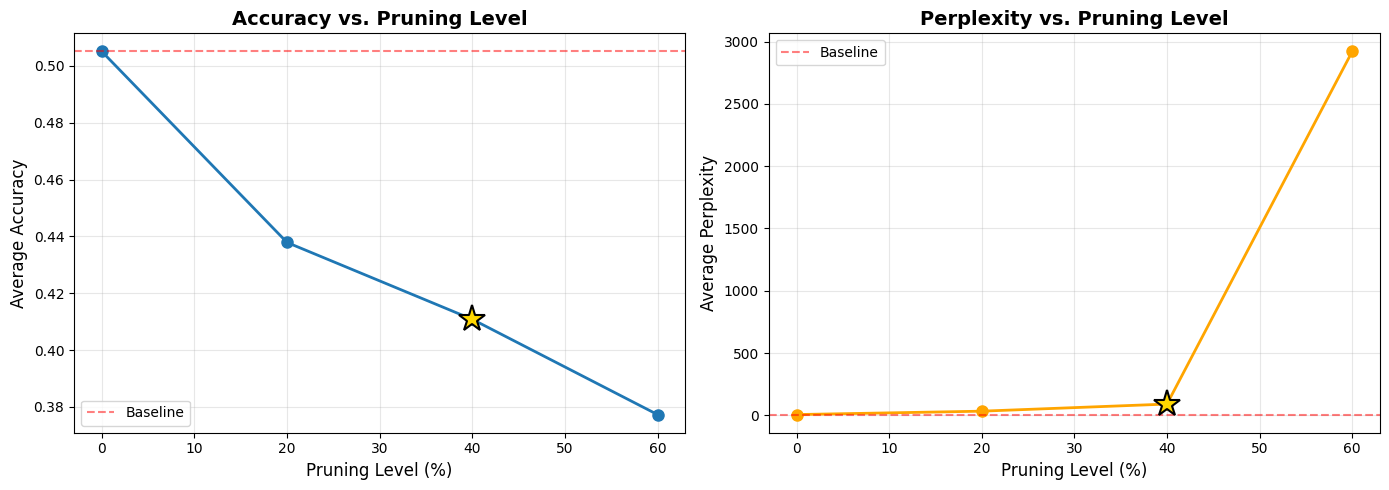


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/llama_1b_performance_analysis.png


In [11]:
# Visualization: Performance across pruning levels
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(summary_df['pruning'], summary_df['avg_accuracy'], marker='o', linewidth=2, markersize=8)
axes[0].axhline(y=baseline_acc, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[0].set_xlabel('Pruning Level (%)', fontsize=12)
axes[0].set_ylabel('Average Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs. Pruning Level', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Highlight star model
star_idx = summary_df[summary_df['star'] == '⭐'].index[0]
axes[0].plot(summary_df.loc[star_idx, 'pruning'], summary_df.loc[star_idx, 'avg_accuracy'],
             marker='*', markersize=20, color='gold', markeredgecolor='black', markeredgewidth=1.5)

# Perplexity plot
axes[1].plot(summary_df['pruning'], summary_df['avg_perplexity'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].axhline(y=baseline_ppl, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[1].set_xlabel('Pruning Level (%)', fontsize=12)
axes[1].set_ylabel('Average Perplexity', fontsize=12)
axes[1].set_title('Perplexity vs. Pruning Level', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Highlight star model
axes[1].plot(summary_df.loc[star_idx, 'pruning'], summary_df.loc[star_idx, 'avg_perplexity'],
             marker='*', markersize=20, color='gold', markeredgecolor='black', markeredgewidth=1.5)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/llama_1b_performance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/llama_1b_performance_analysis.png")

# 7. Decision Matrix: Which Models to Upload?

Based on the evaluation results, determine which models should be uploaded to HuggingFace Hub for Phase 2.

In [16]:
print(f"\n{'='*70}")
print("🎯 DECISION MATRIX: Models for HuggingFace Hub Upload")
print(f"{'='*70}\n")

print("Evaluation Criteria:")
print("  1. Performance degradation < 15% vs baseline")
print("  2. Outperforms or matches baseline in at least 2 tasks")
print("  3. Accuracy degradation < 50% vs baseline")
print("  4. Sufficient parameter reduction to justify storage\n")

# Decision logic
decisions = []

for _, row in summary_df.iterrows():
    if row['pruning'] == 0:
        continue  # Skip baseline

    decision = {
        "model": row['model'],
        "pruning": row['pruning'],
        "expansion": row['expansion'],
        "star": row['star'],
    }

    # Calculate degradation
    acc_degradation = abs((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100) if baseline_acc else 999
    ppl_degradation = abs((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100) if baseline_ppl else 999

    # Decision criteria
    is_star = row['star'] == '⭐'
    good_performance = (acc_degradation < 15 or ppl_degradation < 50)  # Perplexity can vary more

    # Final decision
    if is_star:
        decision['upload'] = True
        decision['reason'] = "Star model (optimal 140% expansion)"
    elif good_performance:
        decision['upload'] = True
        decision['reason'] = f"Good performance (acc: {acc_degradation:.1f}%, ppl: {ppl_degradation:.1f}%)"
    else:
        decision['upload'] = False
        decision['reason'] = f"High degradation (acc: {acc_degradation:.1f}%, ppl: {ppl_degradation:.1f}%)"

    decisions.append(decision)

# Display decision table
print("Upload Decisions:")
print("-" * 100)
print(f"{'Model':<35} {'Pruning':<10} {'Expansion':<12} {'Star':<6} {'Upload?':<10} {'Reason'}")
print("-" * 100)

for dec in decisions:
    upload_status = "✅ YES" if dec['upload'] else "❌ NO"
    print(f"{dec['model']:<35} {dec['pruning']:<10}% {dec['expansion']:<12}% {dec['star']:<6} {upload_status:<10} {dec['reason']}")

print("-" * 100)

# Summary
models_to_upload = sum(1 for d in decisions if d['upload'])
print(f"\n📦 Total models to upload to HF Hub: {models_to_upload}/{len(decisions)}")
print(f"\n✅ PHASE 3 COMPLETE - Ready for Phase 2 (Model Factory)")


🎯 DECISION MATRIX: Models for HuggingFace Hub Upload

Evaluation Criteria:
  1. Performance degradation < 15% vs baseline
  2. Outperforms or matches baseline in at least 2 tasks
  3. Accuracy degradation < 50% vs baseline
  4. Sufficient parameter reduction to justify storage

Upload Decisions:
----------------------------------------------------------------------------------------------------
Model                               Pruning    Expansion    Star   Upload?    Reason
----------------------------------------------------------------------------------------------------
Llama-3.2-1B-pruned-20%             20        % 220         %        ✅ YES      Good performance (acc: 13.3%, ppl: 476.7%)
Llama-3.2-1B-pruned-40%             40        % 140         % ⭐      ✅ YES      Star model (optimal 140% expansion)
Llama-3.2-1B-pruned-60%             60        % 60          %        ❌ NO       High degradation (acc: 25.3%, ppl: 50975.5%)
---------------------------------------------------

In [19]:
# Save complete results for reproducibility and research sharing
print(f"\n{'='*70}")
print("💾 SAVING COMPLETE RESULTS FOR RESEARCH SHARING")
print(f"{'='*70}\n")

# Consolidate all data into a comprehensive JSON
complete_results = {
    "experiment_metadata": {
        "timestamp": datetime.now().isoformat(),
        "notebook": "02_Evaluate_1B.ipynb",
        "model_family": "Llama-3.2-1B",
        "pruning_method": "MAW (Maximum Absolute Weight)",
        #"library_versions": {
        #    "optipfair": optipfair.__version__,
        #    "transformers": transformers.__version__,
        #    "torch": torch.__version__,
        #    "lm_eval": lm_eval.__version__
        #},
        "hardware": {
            "device": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
            "gpu_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else None
        }
    },

    "benchmarks": [
        {"name": task["name"], "num_fewshot": task["num_fewshot"]}
        for task in BENCHMARKS_BASE
    ],

    "models_evaluated": {
        "baseline": {
            "name": "Llama-3.2-1B",
            "pruning_pct": 0,
            "expansion_rate": 300,
            "is_star": False,
            "hf_repo": "meta-llama/Llama-3.2-1B",
            "results": baseline_results
        },
        "pruned_20pct": {
            "name": "Llama-3.2-1B-pruned-20%",
            "pruning_pct": 20,
            "expansion_rate": 220,
            "is_star": False,
            "hf_repo": "peremartra/Llama-3.2-1B-pruned-20pct",
            "results": all_results.get("20pct", {})
        },
        "pruned_40pct": {
            "name": "Llama-3.2-1B-pruned-40%",
            "pruning_pct": 40,
            "expansion_rate": 140,
            "is_star": True,
            "hf_repo": "peremartra/Llama-3.2-1B-pruned-40pct",
            "results": all_results.get("40pct", {})
        },
        "pruned_60pct": {
            "name": "Llama-3.2-1B-pruned-60%",
            "pruning_pct": 60,
            "expansion_rate": 60,
            "is_star": False,
            "hf_repo": "peremartra/Llama-3.2-1B-pruned-60pct",
            "results": all_results.get("60pct", {})
        }
    },

    "summary_statistics": {
        "baseline": {
            "avg_accuracy": float(summary_df.loc[summary_df['pruning'] == 0, 'avg_accuracy'].values[0]),
            "avg_perplexity": float(summary_df.loc[summary_df['pruning'] == 0, 'avg_perplexity'].values[0]),
        },
        "pruned_models": [
            {
                "pruning_pct": int(row['pruning']),
                "expansion_rate": int(row['expansion']),
                "is_star": row['star'] == '⭐',
                "avg_accuracy": float(row['avg_accuracy']) if pd.notna(row['avg_accuracy']) else None,
                "avg_perplexity": float(row['avg_perplexity']) if pd.notna(row['avg_perplexity']) else None,
                "accuracy_degradation_pct": float(((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100)) if baseline_acc and pd.notna(row['avg_accuracy']) else None,
                "perplexity_degradation_pct": float(((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100)) if baseline_ppl and pd.notna(row['avg_perplexity']) else None
            }
            for _, row in summary_df.iterrows() if row['pruning'] > 0
        ]
    },

    "upload_decisions": decisions,

    "citation": {
        "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
        "author": "Pere Martra",
        "doi": "https://doi.org/10.31219/osf.io/qgxea",
        "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
        "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
    }
}

# Save to JSON with pretty formatting
json_path = f"{RESULTS_DIR}/llama_1b_complete_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(json_path, 'w') as f:
    json.dump(complete_results, f, indent=2, ensure_ascii=False)

print(f"✅ Complete results saved to:")
print(f"   {json_path}")

# Also save a "latest" version
latest_json = f"{RESULTS_DIR}/llama_1b_complete_results_latest.json"
with open(latest_json, 'w') as f:
    json.dump(complete_results, f, indent=2, ensure_ascii=False)

print(f"✅ Latest version:")
print(f"   {latest_json}")

# Display file size
file_size_kb = Path(json_path).stat().st_size / 1024
print(f"\n📊 File size: {file_size_kb:.1f} KB")
print(f"📦 Models included: {len(complete_results['models_evaluated'])}")
print(f"📋 Benchmarks per model: {len(BENCHMARKS_BASE)}")
print(f"🔬 Total result entries: {len(df)}")

print(f"\n{'='*70}")
print("✅ COMPLETE RESULTS SAVED - Ready for research sharing")
print(f"{'='*70}\n")


💾 SAVING COMPLETE RESULTS FOR RESEARCH SHARING

✅ Complete results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_20251020_202959.json
✅ Latest version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_latest.json

📊 File size: 8.4 KB
📦 Models included: 4
📋 Benchmarks per model: 11
🔬 Total result entries: 41

✅ COMPLETE RESULTS SAVED - Ready for research sharing



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across 10 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub

### Next Steps:

Based on these results, proceed to:
- **Phase 2 (01_Model_Factory.ipynb):** Create and upload selected models to HF Hub
- **Phase 4 (03_Evaluate_3B.ipynb):** Repeat evaluation for Llama-3.2-3B family
- **Analysis:** Deep dive into task-specific degradation patterns

---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---